In [1]:
import keras
from keras.datasets import mnist
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import imgaug.augmenters as iaa
import cv2
from google.colab.patches import cv2_imshow

import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import random
import pandas as pd
import seaborn as sn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Acquisition des images

In [6]:
labels = ['cardboard','glass','metal','paper','plastic','trash']
#img_size_w = 512
#img_size_h = 384
img_size =250
def read_images(data_dir: str):
    data = []
    for label in labels:
        path = os.path.join(data_dir,label)
        print(path)
        class_num = labels.index(label)
        print(class_num)
        for img in os.listdir(path):
            try:
                #img_arr = cv2.imread(os.path.join(path,img), cv2.COLOR)
                img_arr = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                resized_arr=cv2.resize(img_arr,(img_size,img_size))
                data.append([resized_arr,class_num])
            except Exception as e:
                print(e)
    return np.array(data)

Dataset = read_images('/content/drive/MyDrive/GMC1041/dataset_complet/')

/content/drive/MyDrive/GMC1041/dataset-resized/cardboard
0
/content/drive/MyDrive/GMC1041/dataset-resized/glass
1
/content/drive/MyDrive/GMC1041/dataset-resized/metal
2
/content/drive/MyDrive/GMC1041/dataset-resized/paper
3
/content/drive/MyDrive/GMC1041/dataset-resized/plastic
4
/content/drive/MyDrive/GMC1041/dataset-resized/trash
5


<ipython-input-6-d70f5116df8e>:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [7]:
x = []
y = []
for feature, label in Dataset:
    x.append(feature)
    y.append(label)
#x = np.array(x).reshape(-1, img_size,img_size, 3)
x = np.array(x).reshape(-1, img_size,img_size, 1)
x = x / 255
y = np.array(y)

In [8]:
print(x.shape)
print(y.shape)

(2527, 250, 250, 1)
(2527,)


# Visualisation d'image

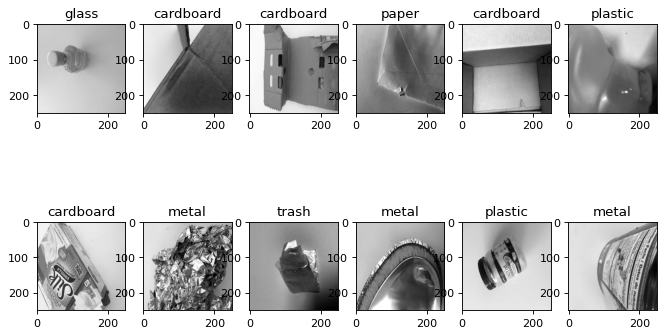

In [12]:
from random import randint
figure(figsize = (10, 6), dpi = 80)
for i in range(12):
    plt.subplot(2,6,i+1)
    rint = randint(0,np.asarray(x).shape[0])
    img = x[rint]
    plt.imshow(img[:,:,0], cmap = 'gray')
    plt.title(labels[y[rint]])
    plt.show

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, "Nombre d'images")

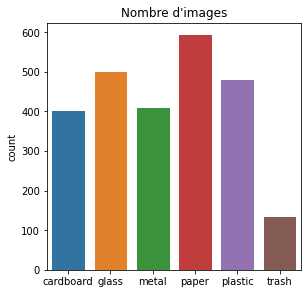

In [13]:
#['cardboard','glass','metal','paper','plastic','trash']
Im = []
for i in Dataset:
    if(i[1]==0):
        Im.append('cardboard')
    elif(i[1]==1):
        Im.append('glass')
    elif(i[1]==2):
        Im.append('metal')
    elif(i[1]==3):
        Im.append('paper')
    elif(i[1]==4):
        Im.append('plastic')
    elif(i[1]==5):
        Im.append('trash')
        
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sn.set_style('darkgrid')
axl = sn.countplot (Im)
axl.set_title('Nombre d\'images')

# Jeu de validation

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
n_values = np.max(y) + 1
Y = np.eye(n_values)[y]
train_X,test_X,train_Y,test_Y = train_test_split(x, Y, test_size = 0.15, random_state = 5)

In [16]:
print(train_X.shape)
print(test_X.shape)
print(train_Y.shape)
print(test_Y.shape)

(2147, 250, 250, 1)
(380, 250, 250, 1)
(2147, 6)
(380, 6)


# Creation du modele

In [22]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), input_shape=(train_X[0].shape), activation='relu', name='Convolution-1'))
model.add(MaxPooling2D(name='MaxPooling2D-1'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', name='Convolution-2'))
model.add(MaxPooling2D(name='MaxPooling2D-2'))
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', name='Convolution-3'))
model.add(MaxPooling2D(name='MaxPooling2D-3'))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', name='Hidden-1'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', name='Hidden-2'))

model.add(Dense(64, activation='relu', kernel_initializer='he_uniform', name='Hidden-3'))
#model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', name='Hidden-4'))
model.add(Dense(6, activation='softmax', name='Output'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Convolution-1 (Conv2D)      (None, 248, 248, 64)      640       
                                                                 
 MaxPooling2D-1 (MaxPooling2  (None, 124, 124, 64)     0         
 D)                                                              
                                                                 
 Convolution-2 (Conv2D)      (None, 122, 122, 32)      18464     
                                                                 
 MaxPooling2D-2 (MaxPooling2  (None, 61, 61, 32)       0         
 D)                                                              
                                                                 
 Convolution-3 (Conv2D)      (None, 59, 59, 16)        4624      
                                                                 
 MaxPooling2D-3 (MaxPooling2  (None, 29, 29, 16)      

In [24]:
es = keras.callbacks.EarlyStopping(monitor='val_accuracy',min_delta=0, patience=4, verbose=2, mode='auto',
                                  restore_best_weights=True)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
history = model.fit(train_X, train_Y,
                    validation_data=(test_X, test_Y),
                    batch_size=64, 
                    epochs=25,
                    callbacks=[es])

Epoch 1/25
34/34 [==============================] - 279s 8s/step - loss: 1.7085 - accuracy: 0.2497 - val_loss: 1.6564 - val_accuracy: 0.2684
Epoch 2/25
34/34 [==============================] - 259s 8s/step - loss: 1.6001 - accuracy: 0.3051 - val_loss: 1.5649 - val_accuracy: 0.3974
Epoch 3/25
34/34 [==============================] - 258s 8s/step - loss: 1.5225 - accuracy: 0.3661 - val_loss: 1.4717 - val_accuracy: 0.3921
Epoch 4/25
34/34 [==============================] - 258s 8s/step - loss: 1.4546 - accuracy: 0.4085 - val_loss: 1.4384 - val_accuracy: 0.4026
Epoch 5/25
34/34 [==============================] - 257s 8s/step - loss: 1.3986 - accuracy: 0.4332 - val_loss: 1.3759 - val_accuracy: 0.4237
Epoch 6/25
34/34 [==============================] - 263s 8s/step - loss: 1.3098 - accuracy: 0.4811 - val_loss: 1.3512 - val_accuracy: 0.4711
Epoch 7/25
34/34 [==============================] - 259s 8s/step - loss: 1.2055 - accuracy: 0.5375 - val_loss: 1.2874 - val_accuracy: 0.5132
Epoch 8/25
34

# Evaluation de la precision

In [26]:
test_loss, test_acc = model.evaluate(test_X, test_Y)
print('Test loss', test_loss)
print('Test accuracy', test_acc)

12/12 [==============================] - 19s 2s/step - loss: 1.3610 - accuracy: 0.5342
Test loss 1.361019253730774
Test accuracy 0.5342105031013489


# Graphique d'apprentissage

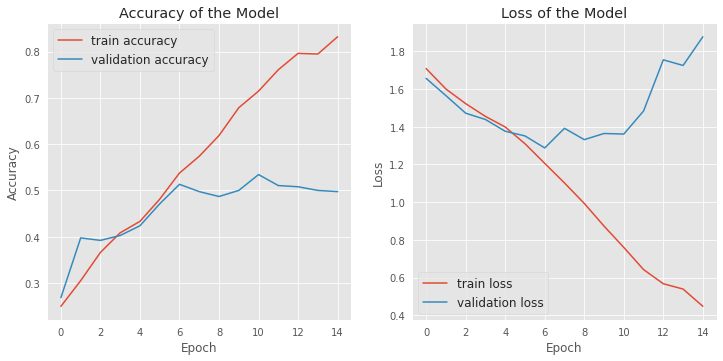

In [27]:
plt.figure(figsize=(12, 12))
plt.style.use('ggplot')
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy of the Model')
plt.ylabel('Accuracy',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.legend(['train accuracy','validation accuracy'],loc='best', prop={'size':12})

plt.subplot(2,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of the Model')
plt.ylabel('Loss',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.legend(['train loss','validation loss'],loc='best', prop={'size':12})

# Voir une prediction

# Construction d'une matrice de confusion

In [30]:
predictions = model.predict(test_X)

12/12 [==============================] - 11s 817ms/step


In [31]:
np.argmax(predictions[0])

2

In [44]:
predictions = model.predict(test_X)
test_preds = np.argmax(predictions, axis = 1)

target_names = np.arange(2)

cm = confusion_matrix(np.argmax(test_Y, axis=1), test_preds)

print(classification_report(np.argmax(test_Y, axis=1), test_preds))

12/12 [==============================] - 10s 831ms/step
              precision    recall  f1-score   support

           0       0.74      0.40      0.52        57
           1       0.40      0.65      0.49        71
           2       0.46      0.54      0.50        61
           3       0.71      0.75      0.73        96
           4       0.47      0.40      0.43        68
           5       0.50      0.07      0.13        27

    accuracy                           0.53       380
   macro avg       0.55      0.47      0.47       380
weighted avg       0.56      0.53      0.52       380



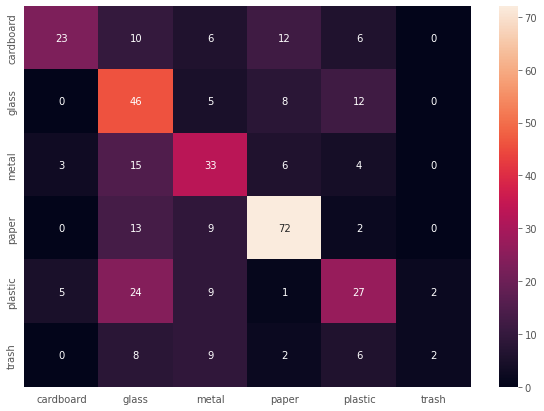

In [49]:
df_cm = pd.DataFrame(cm,index = ['cardboard','glass','metal','paper','plastic','trash'], columns = ['cardboard','glass','metal','paper','plastic','trash'])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True)